### ANN for classification, example 1, mobile phone price class classification

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [108]:
df = pd.read_csv("mobilepricerangeclass.csv")

In [109]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.20,0,1,0,7,0.60,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.50,1,0,1,53,0.70,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.50,1,2,1,41,0.90,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.50,0,0,0,10,0.80,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.20,0,13,1,44,0.60,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [110]:
df['price_range'].value_counts()

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

### We have quite many variables, let's study if we can remove some of them

In [111]:
corr_matrix = df.corr()['price_range']
corr_matrix.sort_values(ascending=False)

price_range      1.00
ram              0.92
battery_power    0.20
px_width         0.17
px_height        0.15
int_memory       0.04
sc_w             0.04
pc               0.03
three_g          0.02
sc_h             0.02
fc               0.02
talk_time        0.02
blue             0.02
wifi             0.02
dual_sim         0.02
four_g           0.01
n_cores          0.00
m_dep            0.00
clock_speed     -0.01
mobile_wt       -0.03
touch_screen    -0.03
Name: price_range, dtype: float64

In [112]:
# let' remove some of the variables that are probably not extremely important in this dataset
# NOTE! we didn't spend much time analyzing/optimizing these, this just an example
# on how you can use correlation matrix, SelectKBest etc. to choose your variables
removables = ['touch_screen', 'dual_sim', 'clock_speed', 'm_dep', 'three_g', 'four_g', 'wifi', 'blue']
df = df.drop(removables, axis=1)

In [113]:
# let's assign actual names for the price classes
# so we have nicer metrics and results later (after training model)
df['price_range'] = df['price_range'].replace({
    0: "1: Cheap",
    1: "2: Avg-",
    2: "3: Avg+",
    3: "4: Expensive"
})

In [114]:
# for easier readability later, let's give proper names for the categories

In [115]:
# everything else except the target variable
X = df.drop("price_range", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['price_range']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

# save the categories into a helper list for later purposes
categories = list(le.classes_)
categories

['1: Cheap', '2: Avg-', '3: Avg+', '4: Expensive']

In [116]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
8,ram,931267.52
6,px_height,17363.57
0,battery_power,14129.87
7,px_width,9810.59
3,mobile_wt,95.97
2,int_memory,89.84
10,sc_w,16.48
11,talk_time,13.24
1,fc,10.14
9,sc_h,9.61


In [117]:
# based on the results of correlation matrix, SelectKBest, Fisher's Score, 
# VIF-test, manual analysis etc etc.
# You can choose which variables to keep and which to drop

### continue with train/test/validation -split!

In [118]:
# this time, let's split the data into 65% (training data) and 35% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35)

# step 2, split the temporary data in HALF (0.5) => 17.5% test and 17.5% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Create the neural network structure

** NOTE: you can use all the same callback features as in regression: ModelCheckpoint, EarlyStop, ReduceLROnPlateau, Dropout-layers...**

In [119]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in classification depends on amount of output options in target variable
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428 (1.67 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 24 (96.00 B)

In [120]:
# train/fit neural network with validation data
# see the instructions on the train/test -split above on how to split the data correctly
model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_val, y_val))

Epoch 1/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2923 - loss: 5.3409 - val_accuracy: 0.2571 - val_loss: 4.9789
Epoch 2/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3031 - loss: 4.5823 - val_accuracy: 0.2943 - val_loss: 4.2446
Epoch 3/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3308 - loss: 3.9048 - val_accuracy: 0.3543 - val_loss: 3.6045
Epoch 4/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3685 - loss: 3.3018 - val_accuracy: 0.4057 - val_loss: 3.0429
Epoch 5/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4369 - loss: 2.7766 - val_accuracy: 0.5314 - val_loss: 2.5395
Epoch 6/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5046 - loss: 2.3148 - val_accuracy: 0.5543 - val_loss: 2.0860
Epoch 7/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5308 - loss: 1.9173 - val_accuracy: 0.5743 - val_loss: 1.7043
Epoch 8/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5477 - loss: 1.5886 - val_accuracy: 0.5943 - v

### Error and performance metrics

<Axes: >

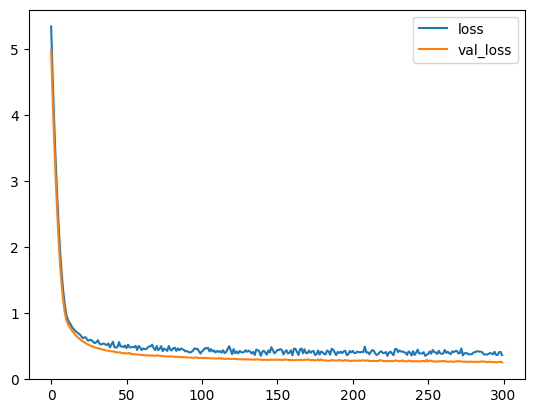

In [121]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

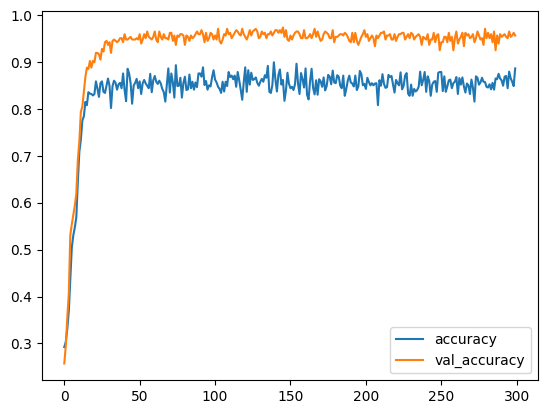

In [122]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [123]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.2362147569656372, 0.9657142758369446]

Train data evaluation:
[0.24075399339199066, 0.9623076915740967]


In [124]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


<Axes: >

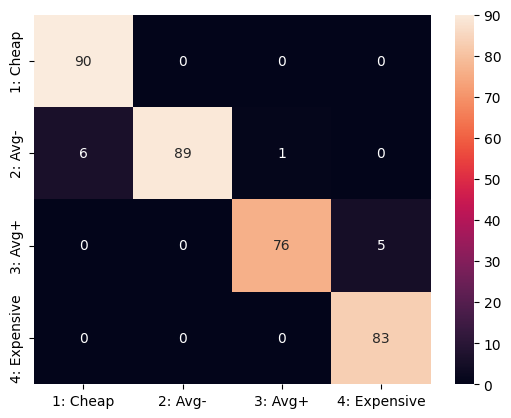

In [125]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

In [126]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

    1: Cheap       0.94      1.00      0.97        90
     2: Avg-       1.00      0.93      0.96        96
     3: Avg+       0.99      0.94      0.96        81
4: Expensive       0.94      1.00      0.97        83

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350


Model overall accuracy: 96.57%


In [127]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary classification, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


0.9988023333333333

### Test the model in practice with new data

In [128]:
X.columns

Index(['battery_power', 'fc', 'int_memory', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'],
      dtype='object')

In [131]:
df.head(3)

,battery_power,fc,int_memory,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
0,842,1,7,188,2,2,20,756,2549,9,7,19,2: Avg-
1,1021,0,53,136,3,6,905,1988,2631,17,3,7,3: Avg+
2,563,2,41,145,5,6,1263,1716,2603,11,2,9,3: Avg+


In [136]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'battery_power': 1021, 
    'fc': 0, 
    'int_memory': 53, 
    'mobile_wt': 136, 
    'n_cores': 3, 
    'pc': 6,
    'px_height': 905, 
    'px_width': 1988, 
    'ram': 3031, 
    'sc_h': 17, 
    'sc_w': 3, 
    'talk_time': 7 
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

# switch to decimal representation 
np.set_printoptions(precision=9, suppress=True)

# 0 cheapest, 3 most expensive
print(f"Predicted price range: {result_text}")
print()
print("Probabilities by class:")
print(categories)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted price range: 4: Expensive

Probabilities by class:
['1: Cheap', '2: Avg-', '3: Avg+', '4: Expensive']
[0.          0.000056774 0.11943996  0.88050324 ]
